In [1]:
# Objective, Can you correctly classify the medical specialties based on the transcription text
#Let us import all the necessary libraries
import os
import numpy as np  
import pandas as pd 
import time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
import re, string
from sklearn.model_selection import RandomizedSearchCV
from nltk import word_tokenize, sent_tokenize

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer,LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


import warnings
warnings.filterwarnings("ignore")

In [4]:
! pip install nltk
import nltk
from nltk.corpus import stopwords

# Download the stopwords dataset if not already downloaded
nltk.download('stopwords')

# Use the stopwords
stop_words = set(stopwords.words('english'))

#EDA
data = pd.read_csv('/kaggle/input/medicaltranscriptions/mtsamples.csv')
print(data.columns)
#data.head(5)

data.drop('Unnamed: 0',axis=1,inplace=True)

data.columns

# a function to preprocess the data
def Preprocessing(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    text = re.sub('"','', text) 
    text = re.sub(r"'s\b","",text)
    text = re.sub("[^a-zA-Z]", " ", text) 
    tokens = [w for w in text.split() if not w in stop_words]
    long_words = [i for i in tokens if len(i)>=3]
    return (" ".join(long_words)).strip()

data['cleaned_transcription'] = data['transcription'].apply(Preprocessing)

print(data.columns)

# creating feature vectors and target vector
transcripts = data.cleaned_transcription.values
Y = data.medical_specialty.values

# label encode our categorical target variable
le = LabelEncoder()
Y = le.fit_transform(Y)

print(Y)

# function to create document-term matrix
def create_vec(strings):
  #tf = TfidfVectorizer(analyzer="char_wb", ngram_range=(1,3))
  tf = TfidfVectorizer(max_features = 6000, ngram_range=(1,3), min_df=5, max_df=0.9)
  tf.fit(strings)
  X = tf.fit_transform(strings)
  return X
vecs = create_vec(transcripts)# a function to preprocess the data

print(vecs)

# applying SMOTE oversampling method to upsample minority class labels
sm = SMOTE()
x_res, y_res = sm.fit_resample(vecs,Y)

df = pd.DataFrame({"class":list(y_res)})
df.head()

df['class'].value_counts()

# Splitting data into train:test by 80:20
x_train, x_val, y_train, y_val = train_test_split(x_res, y_res, test_size=0.2, random_state = 42)

x_train = x_train.toarray()
print('\nTraining features shape: ',x_train.shape)

x_val =x_val.toarray()
print('Test features shape:     ',x_val.shape)

# a function to train and evaluate model
def train_model(model, x_train,x_val,y_train,y_val):
  model.fit(x_train,y_train)
  prediction = model.predict(x_val)
  print('Accuracy',round(accuracy_score(prediction, y_val)*100, 0),'%')
  return model

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Index(['Unnamed: 0', 'description', 'medical_specialty', 'sample_name',
       'transcription', 'keywords'],
      dtype='object')
Index(['description', 'medical_specialty', 'sample_name', 'transcription',
       'keywords', 'cleaned_transcription'],
      dtype='object')
[0 2 2 ... 0 0 0]
  (0, 3314)	0.09403042310250295
  (0, 908)	0.10238291501134683
  (0, 4064)	0.10735828324847223
  (0, 3528)	0.091052388350128
  (0, 5987)	0.07621250555094665
  (0, 5176)	0.1047122232206365
  (0, 5408)	0.10566288771279468
  (0, 149)	0.11042100614514046
  (0, 2991)	0.06482340517448347
  (0, 5920)	0.10599037032882767
  (0, 5229)	0.09315652072007759
  (0, 3313)	0.06423350875032413
  (0, 907)	0.09820037674998712
  (0, 5455)	0.1047122232206365
  (0, 3296)	0.10440537031218039
  (0, 573)	0.05168030582444491
  (0, 4063)	0.10735828324847223
  (0, 5861)	0.0747634135990948
  (0, 151)	0.07360

In [5]:
# Logistic Regression classification model
classifier = LogisticRegression()

# Define the parameter distribution for hyperparameter tuning (you can adjust these based on your needs)
param_dist = {
    'C': [0.1, 1, 10],  # Regularization strength (log scale for more exploration)
    'solver': ['liblinear', 'lbfgs', 'saga'],  # Solver to use for optimization
    'max_iter': [100, 250, 500, 1000],  # Maximum number of iterations for the solvers
    'penalty': ['l2', 'l1', 'elasticnet'],  # Regularization penalty
    'multi_class': ['auto', 'ovr', 'multinomial'],  # Multi-class strategy
    'fit_intercept': [True, False],  # Whether to include the intercept term in the model
    'class_weight': [None, 'balanced'],  # Weigh classes differently in imbalanced datasets
    'tol': [1e-5, 1e-3],  # Tolerance for stopping criteria
}

# Set up RandomizedSearchCV for hyperparameter tuning with cross-validation
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, 
                                   n_iter=10, cv=10, n_jobs=-1, verbose=1, scoring='accuracy', random_state=42)

# Train the model with RandomizedSearchCV (this will automatically handle cross-validation and hyperparameter tuning)
random_search.fit(x_train, y_train)

# Print the best parameters and the best score found by RandomizedSearchCV
print(f"Best parameters from RandomizedSearchCV: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_}")

# Use the best estimator found by RandomizedSearchCV
best_classifier = random_search.best_estimator_

# Cross-validation results with the best model (10-fold cross-validation)
cv_results = cross_validate(best_classifier, x_train, y_train, cv=10)

# Print cross-validation results (accuracy, fit time, score time)
print("Cross-validation results: ", cv_results)

# Logistic Regression classification report using the best model
prediction = best_classifier.predict(x_val)

# Print classification report (with the correct order for y_true and y_pred)
print('Classification report for Logistic Regression: \n', classification_report(y_val, prediction, target_names=list(le.classes_), digits=4))

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters from RandomizedSearchCV: {'tol': 1e-05, 'solver': 'liblinear', 'penalty': 'l2', 'multi_class': 'ovr', 'max_iter': 500, 'fit_intercept': False, 'class_weight': 'balanced', 'C': 1}
Best cross-validation score: 0.8294141781130367
Cross-validation results:  {'fit_time': array([114.45485473, 113.26357317, 113.29626846, 117.63414145,
       127.61017871, 127.20992398, 127.87315464, 128.4604497 ,
       128.22800946, 128.4582305 ]), 'score_time': array([0.06282187, 0.06018281, 0.05919099, 0.07971787, 0.08764768,
       0.06112576, 0.06183386, 0.05895758, 0.09754276, 0.05934167]), 'test_score': array([0.82577904, 0.82606232, 0.83087819, 0.83031161, 0.82436261,
       0.83626062, 0.82941343, 0.83253046, 0.82601303, 0.83253046])}
Classification report for Logistic Regression: 
                                 precision    recall  f1-score   support

          Allergy / Immunology     0.8630    1.0000    0.9264       2

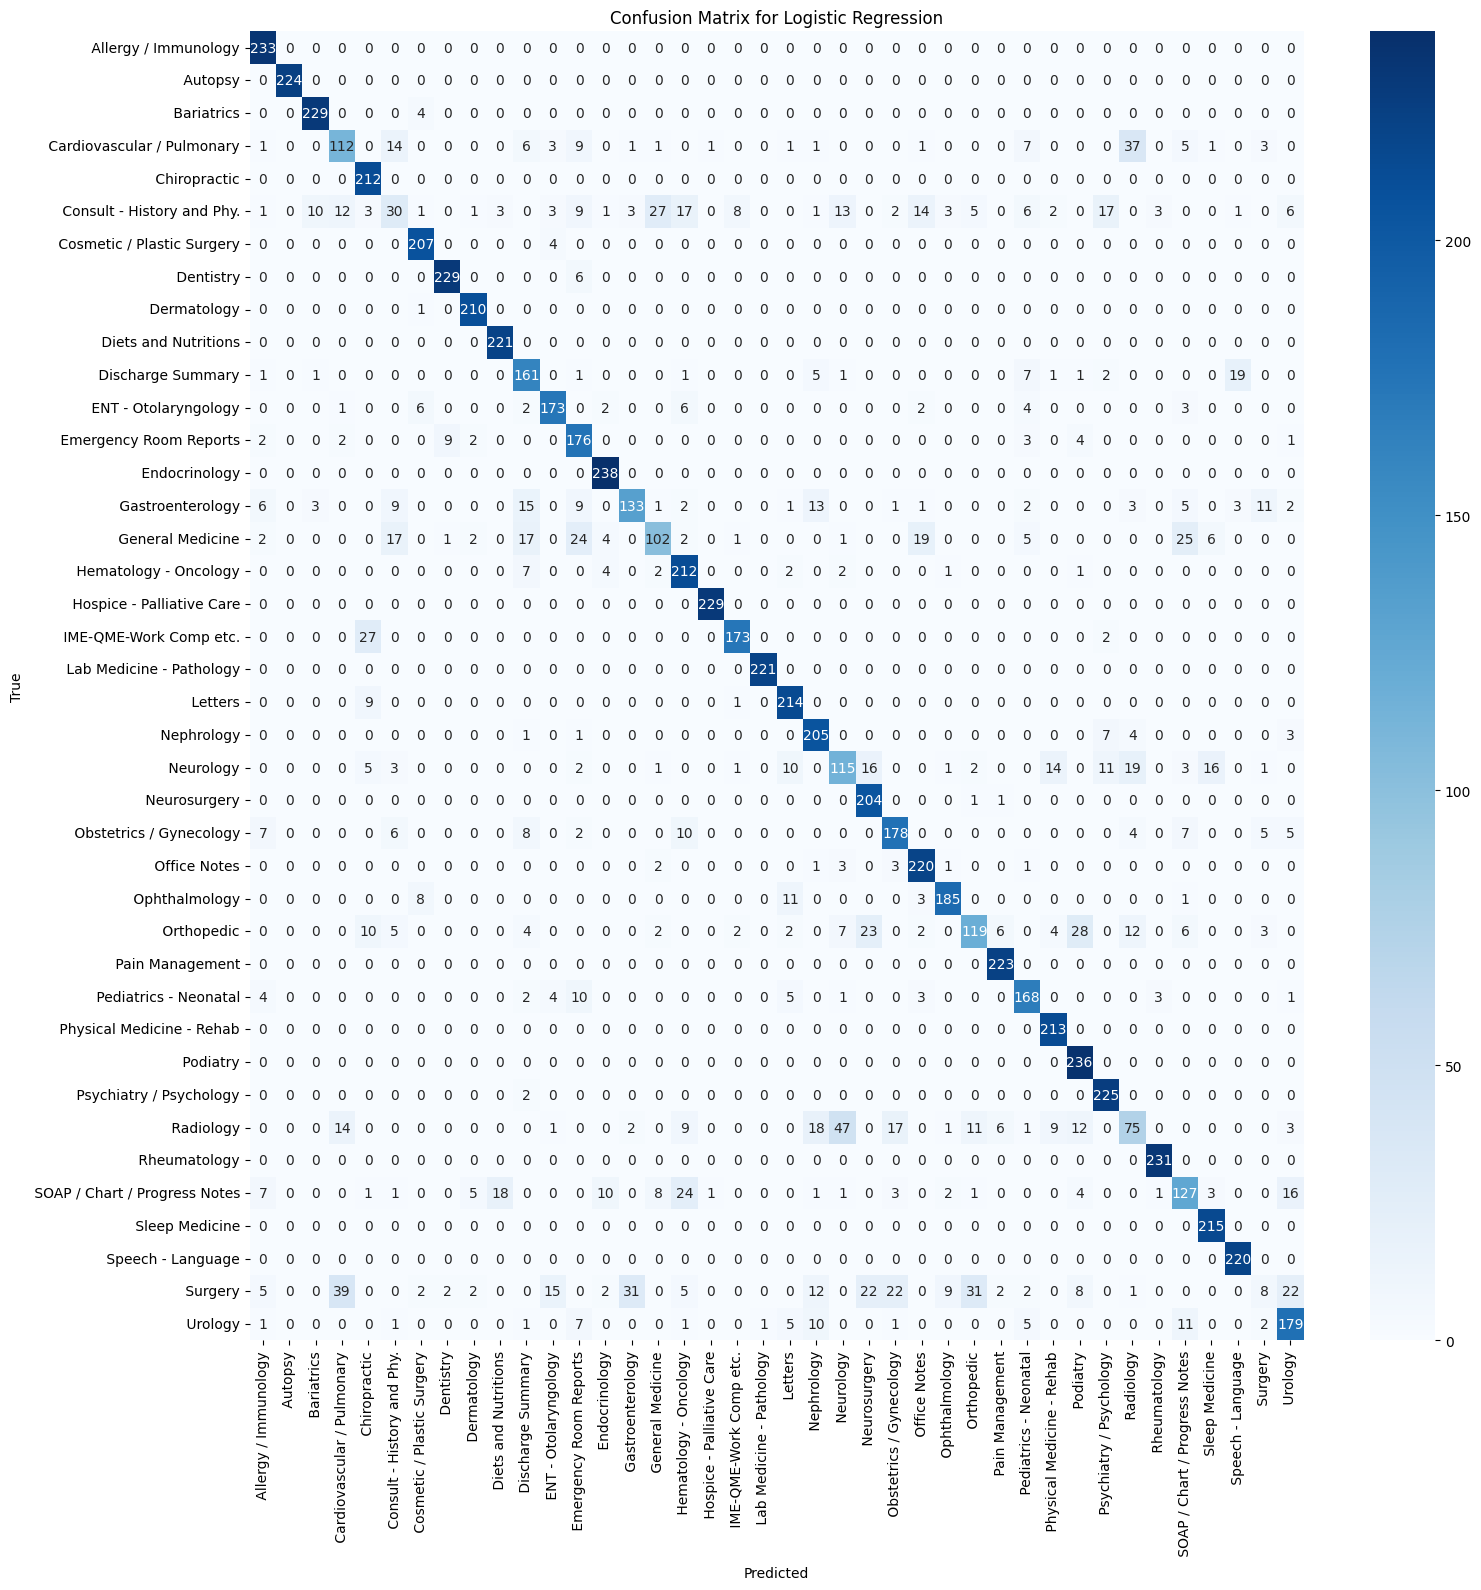

In [6]:
# Confusion Matrix Logistic Regression
conf_matrix = confusion_matrix(y_val, prediction)

# Plotting the confusion matrix
plt.figure(figsize=(17, 17))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()